In [1]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install --quiet azure-cognitiveservices-vision-face
import cv2
import matplotlib.pyplot as plt
import glob, os

In [2]:
key = '0a719f98e2744c98a0b34c7e30879ec8'
endpoint = 'https://westcentralus.api.cognitive.microsoft.com/' 

In [3]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

In [4]:
path = 'images/gates/*'

In [9]:
import time
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fnames = glob.glob(path)

filenames = []
images = []
imagepoints = []
cli.face.detect_with_url('https://soshnikov.com/images/official/shwars_geek.jpg')
for fn in fnames:
    time.sleep(5)
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Processing images/gates\gates_0.jpg
Processing images/gates\gates_1.jpg
Processing images/gates\gates_10.jpg
Processing images/gates\gates_11.jpg
Processing images/gates\gates_12.jpg
Processing images/gates\gates_13.jpg
Processing images/gates\gates_14.jpg
Processing images/gates\gates_15.jpg
Processing images/gates\gates_16.jpg
Processing images/gates\gates_17.jpg
Processing images/gates\gates_19.jpg
Processing images/gates\gates_2.jpg
Processing images/gates\gates_21.jpg
Processing images/gates\gates_22.jpg
Processing images/gates\gates_23.jpg
Processing images/gates\gates_24.jpg
Processing images/gates\gates_25.jpg
Processing images/gates\gates_26.jpg
Processing images/gates\gates_27.jpg
Processing images/gates\gates_28.jpg
Processing images/gates\gates_29.jpg
Processing images/gates\gates_3.jpg
Processing images/gates\gates_30.jpg
Processing images/gates\gates_31.jpg
Processing images/gates\gates_33.jpg
Processing images/gates\gates_34.jpg
Processing images/gates\gates_35.jpg
Proce

как пример, только без опоры на глаза, а на нос(проба сил и понимания процесса):

In [517]:


target_triangle = np.float32([[130.0,120.0],[150.0,120.0],[140.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x'] + attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['nose_root_left']['x'],attrs['nose_root_left']['y']),
                                            (attrs['nose_root_right']['x'],attrs['nose_root_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]

In [518]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    return res.astype(np.ubyte)

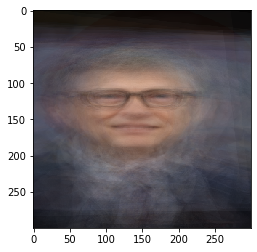

In [519]:
res = merge(img_aligned)
plt.imshow(res)

In [520]:
cv2.imwrite('results/gates_1.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True

Для следующего рисунка можно даже подвязать глубокую мысль о вечном "голоде" даже одного из богатейших людей или о том, как люди верят словам... Словом, художесвтенный эффект явно присутствует.

In [466]:
def g(f, fl):
    mc_x = (f['mouth_left']['x'] + f['mouth_right']['x']) / 2.0
    mc_y = (f['mouth_left']['y'] + f['mouth_right']['y']) / 2.0
    a = abs(f['pupil_left']['x'] - mc_x)
    b = abs(f['pupil_left']['y'] - mc_y)
    return [a, b]

def g1(f, fl):
    a = abs(f['pupil_left']['x'] - f['pupil_right']['x'])
    b = abs(f['pupil_left']['y'] - f['pupil_right']['y'])   
    return [a, b]

def alf(f, fl):
    mc_x = (f['mouth_left']['x'] + f['mouth_right']['x']) / 2.0
    mc_y = (f['mouth_left']['y'] + f['mouth_right']['y']) / 2.0
    ba = [f['pupil_left']['x'] - f['pupil_right']['x'], f['pupil_left']['y'] - f['pupil_right']['y']]
    bc = [f['pupil_left']['x'] - mc_x, f['pupil_left']['y'] - mc_y]
    
    cosine_angle = np.dot(ba,bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.arccos(cosine_angle) 
    

In [467]:
rast = [g(a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

In [468]:
rast_pup = [g1(a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

alfa = [alf(a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

In [521]:
n_ppl = 9
da = pi/36

radius = 3*np.mean(rast[:][0])
def get_tri(i):
    a = -pi/4 - i%3*pi/4
    x1 = width/2
    y1 = height/2
    x2 = width/2+radius*2*cos(a+da)
    y2 = height/2+radius*2*sin(a+da)
    x3 = width/2+(radius)*2*cos(a-da)
    y3 = height/2+(radius)*2*sin(a-da)
    return [(x1,y1),(x2,y2),(x3,y3)]

triangles = [ get_tri(i) for i in range(n_ppl)]


def get_transform(f,flag):
    flag = min(flag,len(triangles)-1)
    mc_x = (f['mouth_left']['x']+f['mouth_right']['x'])/2.0
    mc_y = (f['mouth_left']['y'] + f['mouth_right']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(mc_x,mc_y),(f['pupil_left']['x'],f['pupil_left']['y']),(f['pupil_right']['x'],f['pupil_right']['y'])]),
                                np.float32(triangles[flag]))


def transform(img,pts,flag):
    tr = get_transform(pts,flag)
    return cv2.warpAffine(img,tr,(width,height))

img_aligned = [transform(i,a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

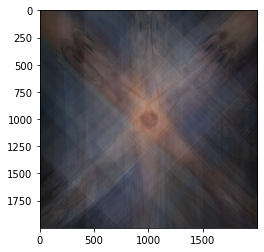

In [522]:
res = merge(img_aligned)
plt.imshow(res)

In [523]:
cv2.imwrite('results/gates_rot.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True

Попытки сделать космические туманности и черные дыры...

In [92]:
from math import sqrt


In [524]:
from math import sin,cos,pi
import numpy as np

width = 2000
height = 2000
radius = 500
n_ppl = 28
da = pi/24

def get_tri(i):
    centr = [width/2, height*0.5]# if i%3 == 0 else [width*0.15, height*0.15] if i%3 == 1 else [width*0.85, height*0.15]
    a = i*2*pi/100
    x1 = centr[0]
    y1 = centr[1]
    x3 = x1 + radius*cos(a)
    y3 = y1 + radius*sin(a+da)#rast_pup[i][0]*sin(a)
    x2 = x1 + radius*cos(a-da)#rast_pup[i][0]*sin(a-da)#(sqrt(rast[i][0]**2 + rast[i][1]**2))*cos(a - alfa[i])
    y2 = y1 + radius*sin(a-da)#rast_pup[i][0]*sin(a-da)#(sqrt(rast[i][0]**2 + rast[i][1]**2))*sin(a - alfa[i])
    return [(x1,y1),(x2,y2),(x3,y3)]

triangles = [ get_tri(i) for i in range(n_ppl)]

def get_transform(f,flag):
    flag = min(flag,len(triangles)-1)
    mc_x = (f['mouth_left']['x'] + f['mouth_right']['x']) / 2.0
    mc_y = (f['mouth_left']['y'] + f['mouth_right']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['pupil_left']['x'],f['pupil_left']['y']),(f['pupil_right']['x'],f['pupil_right']['y']),(mc_x,mc_y)]),
                                np.float32(triangles[flag]))

def transform(img,pts,flag):
    tr = get_transform(pts,flag)
    return cv2.warpAffine(img,tr,(width,height))

In [525]:
img_aligned = [transform(i,a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

In [526]:
def merge(images,wts=None,normalize=True):
    images = list(images)
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    if normalize:
        mi = res.min()
        ma = res.max()
        res = 255.0*(res-mi)/(ma-mi)
    return res.astype(np.ubyte)

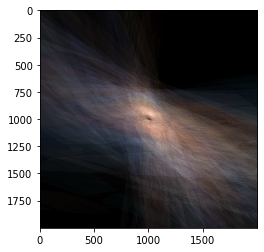

In [527]:
res = merge(img_aligned)
plt.imshow(res)

In [528]:
cv2.imwrite('results/gates_blackhole.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True

In [529]:
def get_tri(i):
    a = i*2*pi/n_ppl
    x1 = width/2+radius*cos(a-da)
    y1 = height/2+radius*sin(a-da)
    x2 = width/2+radius*cos(a+da)
    y2 = height/2+radius*sin(a+da)
    x3 = width/2+(radius-150)*cos(a)
    y3 = height/2+(radius-150)*sin(a)
    return [(x1,y1),(x2,y2),(x3,y3)]

triangles = [ get_tri(i) for i in range(n_ppl)]

In [530]:
n_ppl = 28

def get_transform(f,flag):
    flag = min(flag,len(triangles)-1)
    mc_x = (f['mouth_left']['x']+f['mouth_right']['x'])/2.0
    mc_y = (f['mouth_left']['y'] + f['mouth_right']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['nose_root_left']['x'],f['nose_root_left']['y']),(f['nose_root_right']['x'],f['nose_root_right']['y']),(mc_x,mc_y)]),
                                np.float32(triangles[flag]))

def transform(img,pts,flag):
    tr = get_transform(pts,flag)
    return cv2.warpAffine(img,tr,(width,height))

img_aligned = [transform(i,a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

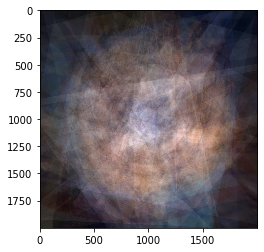

In [531]:
res = merge(img_aligned)
plt.imshow(res)

In [532]:
cv2.imwrite('results/gates_cosmos.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True